In [44]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd

## Simpson's Paradox

Simpson's paradox arises when a trend visible in all of a series of discrete groups is no longer displayed by the composite of those groups.

A well-known example pertains to graduate admissions at the University of California: Berkely. Overall admission figures in 1973 showed a statistically significant bias in acceptance rates for male applicants compared to female applicants. However, in the majority of individual departments the acceptance rates were biased in favor of female applicants. 

Let's examine the data.

In [45]:
bk = pd.read_csv("https://waf.cs.illinois.edu/discovery/berkeley.csv")
bk = bk.drop('Year', axis=1)
bk = bk[bk.Major != "Other"] # Drop the "other" category as its already a composite of many individual categories, and thus already victim to the very paradox we're describing!

grouped = bk.groupby('Major')
majors = grouped['Major'].unique()
majors = [m[0] for m in majors]

headers = {"Major" : [], "Applicants" : [], "Acceptance" : [], "Male Applicants" : [], "Male Acceptance" : [], "Male Population Percentage": [], \
           "Female Applicants" : [], "Female Acceptance" : [], "Female Population Percentage" : []}
rates = pd.DataFrame(headers)

bkgdr = bk.groupby('Gender')

for major in majors:
    m = {}
    gdr = grouped.get_group(major).groupby('Gender')

    m["Major"] = major
    m["Applicants"] = len(grouped.get_group(major))
    m["Acceptance"] = [grouped.get_group(major)['Admission'].value_counts()['Accepted'] / len(grouped.get_group(major))]
    m["Male Applicants"] = len(gdr.get_group('M'))    
    m["Male Acceptance"] = [gdr.get_group('M')['Admission'].value_counts()['Accepted'] / len(gdr.get_group('M'))]
    m["Male Population Percentage"] = [len(gdr.get_group('M'))/len(bkgdr.get_group('M'))]
    m["Female Applicants"] = len(gdr.get_group('F'))    
    m["Female Acceptance"] = [gdr.get_group('F')['Admission'].value_counts()['Accepted'] / len(gdr.get_group('F'))]
    m["Female Population Percentage"] = [len(gdr.get_group('F'))/len(bkgdr.get_group('F'))]
    rates = pd.concat([rates, pd.DataFrame(m)])
    rates = rates.reset_index(drop=True)

m = {}
m["Major"] = "Composite"
m["Applicants"] = len(bk)
m["Acceptance"] = [bk['Admission'].value_counts()['Accepted'] / len(bk)]
m["Male Applicants"] = len(bkgdr.get_group('M'))    
m["Male Acceptance"] = [bkgdr.get_group('M')['Admission'].value_counts()['Accepted'] / len(bkgdr.get_group('M'))]
m["Female Applicants"] = len(bkgdr.get_group('F'))    
m["Female Acceptance"] = [bkgdr.get_group('F')['Admission'].value_counts()['Accepted'] / len(bkgdr.get_group('F'))]
m["Male Population Percentage"] = [1]
m["Female Population Percentage"] = [1]
rates = pd.concat([rates, pd.DataFrame(m)])
rates = rates.reset_index(drop=True)

rates['Applicants'] = rates['Applicants'].astype(int)
rates['Male Applicants'] = rates['Male Applicants'].astype(int)
rates['Female Applicants'] = rates['Female Applicants'].astype(int)

readable = rates.style.format({
    'Acceptance': '{:,.2%}'.format,
    'Male Acceptance': '{:,.2%}'.format,
    'Female Acceptance': '{:,.2%}'.format,
})
readable


,Major,Applicants,Acceptance,Male Applicants,Male Acceptance,Male Population Percentage,Female Applicants,Female Acceptance,Female Population Percentage
0,A,1246,73.35%,1138,72.50%,0.378828,108,82.41%,0.058856
1,B,585,63.25%,560,63.04%,0.186418,25,68.00%,0.013624
2,C,918,34.97%,325,36.92%,0.108189,593,33.90%,0.323161
3,D,792,33.96%,417,33.09%,0.138815,375,34.93%,0.204360
4,E,584,25.17%,191,27.75%,0.063582,393,23.92%,0.214169
5,F,714,6.58%,373,5.90%,0.124168,341,7.33%,0.185831
6,Composite,4839,42.74%,3004,50.30%,1.000000,1835,30.35%,1.000000


As we can see, female acceptance rates are higher in 4/6 majors, yet male acceptance rates are *markedly* higher overall. This is in spite of female applicants having a higher acceptance rate to both of the largest programs. Yet the cause of this apparent 'paradox' is already visible within this table, if you know where to look.

To examine it, let's first display each major's admissions as a bar graph.

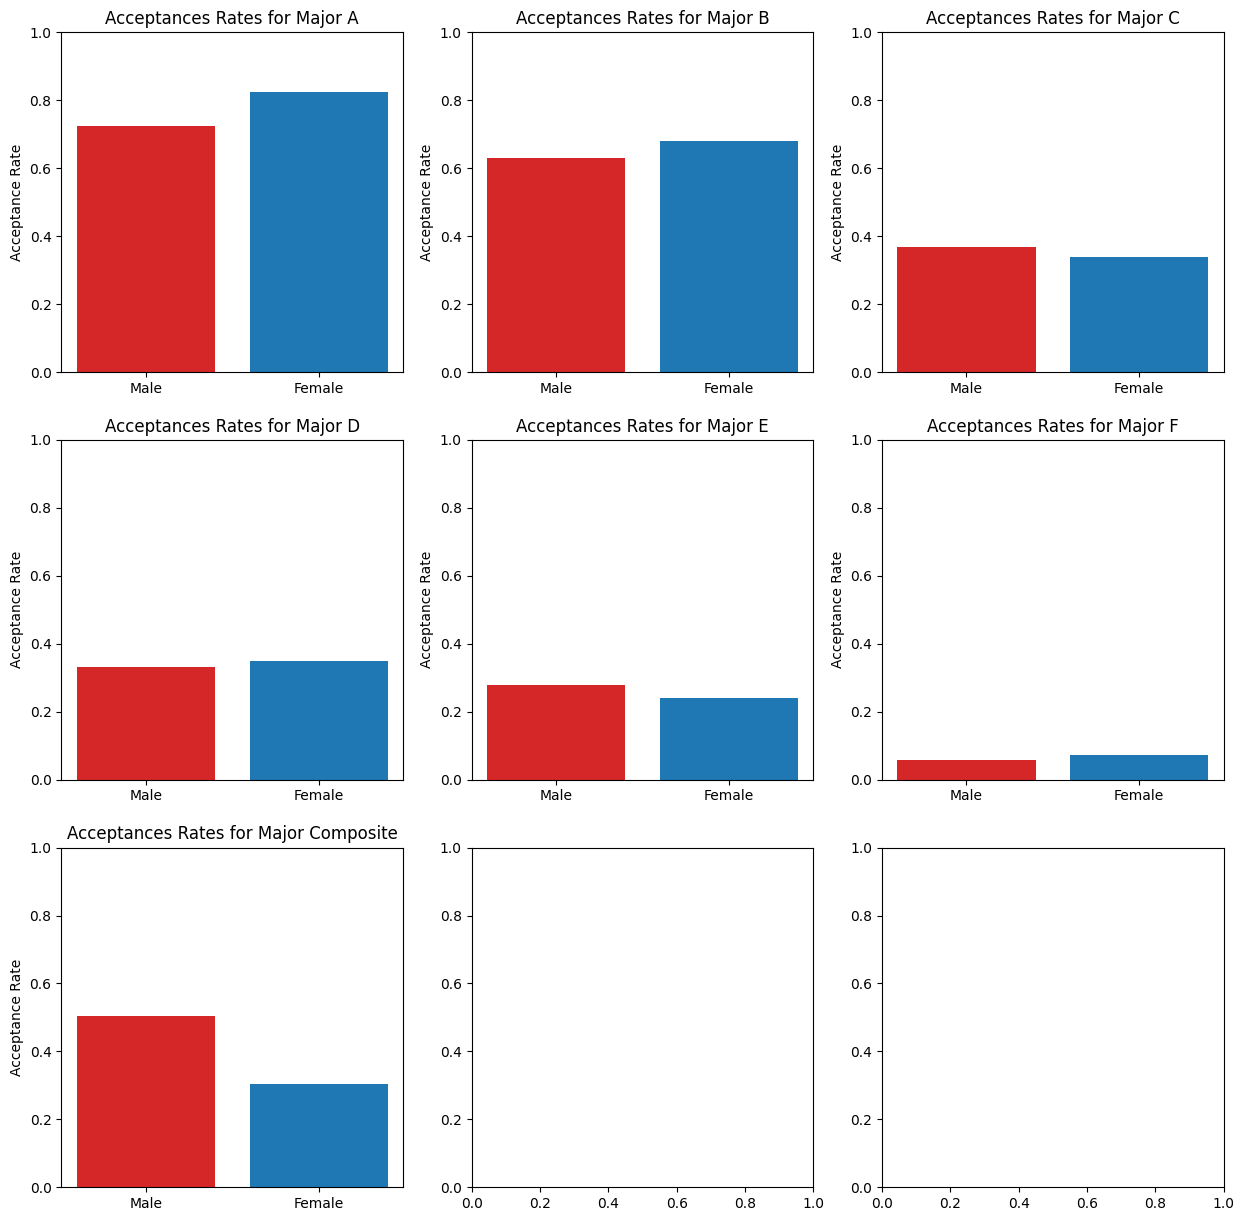

In [46]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(3, 3)
bar_labels = ['male', 'female']
bar_colors = ['tab:red', 'tab:blue']

i = 0
for index, row in rates.iterrows():
    axis[(int)(i/3),(i%3)].bar(["Male", "Female"], [row['Male Acceptance'],row['Female Acceptance']], label=bar_labels, color=bar_colors)

    axis[(int)(i/3),(i%3)].set_ylabel('Acceptance Rate')
    axis[(int)(i/3),(i%3)].set_title('Acceptances Rates for Major {}'.format(row['Major']))
    axis[(int)(i/3),(i%3)].set_ybound(0, 1)

    i += 1

figure.set_figwidth(15)
figure.set_figheight(15)
plt.show()


This confirms what was already visible: individual acceptance rates are 3:2 in favor of female applicants, yet our overall acceptance rates is very heavily male biased. Where is this stark difference in ratios coming from? 

The "paradox" can be dispelled by including a bit of additional information in these graphs... specifically, the percentage of *overall applicants* to the school which were accepted to this major. And then we'll trim a bit of excess data to compare the average (ungendered) acceptance rate of each major with these applicant percentages.

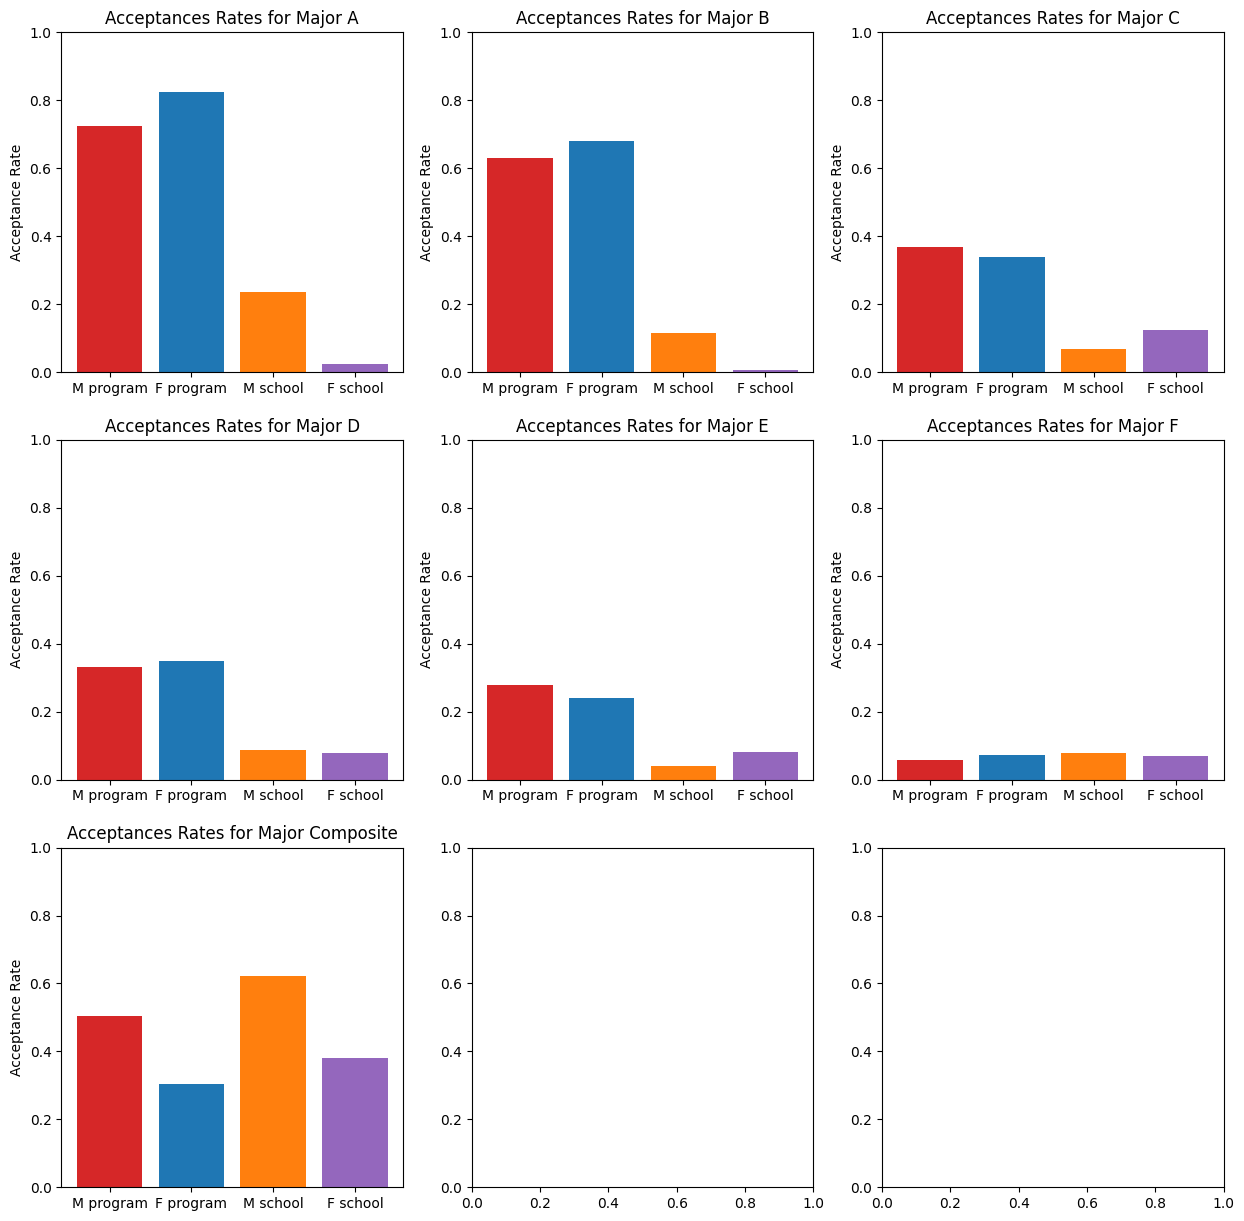

,Major,Acceptance,Male Population Percentage,Female Population Percentage
0,A,0.733547,0.378828,0.058856
1,B,0.632479,0.186418,0.013624
2,C,0.349673,0.108189,0.323161
3,D,0.339646,0.138815,0.204360
4,E,0.251712,0.063582,0.214169
5,F,0.065826,0.124168,0.185831
6,Composite,0.427361,1.000000,1.000000


In [47]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(3, 3)
bar_labels = ['male program rate', 'female program rate', 'male school rate', 'female school rate']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:purple']

i = 0
for index, row in rates.iterrows():
    axis[(int)(i/3),(i%3)].bar(['M program', 'F program', 'M school', 'F school'], [row['Male Acceptance'],row['Female Acceptance'], (row['Male Applicants'])/len(bk),(row['Female Applicants'])/len(bk)], label=bar_labels, color=bar_colors)

    axis[(int)(i/3),(i%3)].set_ylabel('Acceptance Rate')
    axis[(int)(i/3),(i%3)].set_title('Acceptances Rates for Major {}'.format(row['Major']))
    axis[(int)(i/3),(i%3)].set_ybound(0, 1)

    i += 1

figure.set_figwidth(15)
figure.set_figheight(15)
plt.show()

df = rates.drop(['Applicants','Male Applicants','Male Acceptance','Female Applicants','Female Acceptance'], axis=1)
df


Can you see it yet? One more graph for the road.

C:\Users\William Coffey\AppData\Local\Temp\ipykernel_5324\1440528468.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rates = rates.drop(rates[(df.Major == 'Composite')].index)


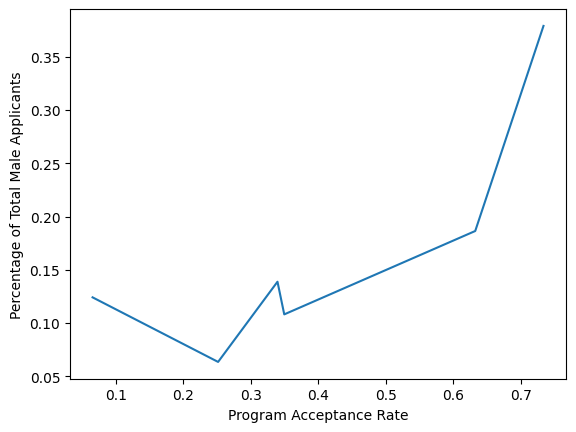

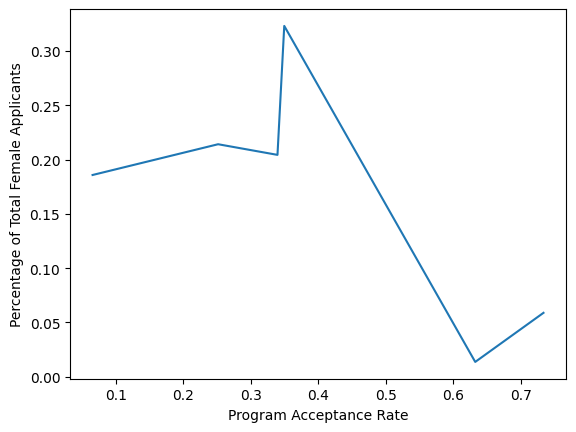

In [52]:
rates = rates.drop(rates[(df.Major == 'Composite')].index)

plt.xlabel("Program Acceptance Rate")
plt.ylabel("Percentage of Total Male Applicants")
plt.plot(rates["Acceptance"], rates["Male Population Percentage"])
plt.show()

plt.xlabel("Program Acceptance Rate")
plt.ylabel("Percentage of Total Female Applicants")
plt.plot(rates["Acceptance"], rates["Female Population Percentage"])
plt.show()

And here in lies the trick: Female applicants applied disproportionately to programs which accepted the least students overall! While large programs like A and B accepted female students at a higher *rate*, more male students applied to these programs overall and thus more were admitted in terms of actual student count. Meanwhile, even when female applicants performed at a better rate for smaller programs like E and F, the total student count that these programs contributed was small.

The root of this paradox comes from:

A. The fact that different programs have different intrinsic acceptance rates.
B. The uneven distribution of gender between these heterogeneous programs.



When we introduce concrete numbers into the narrative, the problem starts to become a lot more intuitive. For example, consider if you are told that:

* 50% of men and 60% of women were admitted to one program
* 5% of men and 10% of  women were admitted to another program
* Overall, a higher percentage of men were admitted than of women

you might be justifiably confused. How do do female applicants have a higher success rate in any given case, but a lower success rate overall? But as we've shown above, the answer lies in recognizing that the 'losers' in each scenario are not necessarily equivalent. That 60% may represent 60% of a very small fraction of the full female applicant pool (ie, a small number of 'successes') while the 10% may represent a very large fraction of the full female applicant pool (ergo, the 90% who were rejected represent a very large number of 'failures'). We can demonstrate this easily by attaching some extreme numbers to this hypothetical. Imagine that:

* 50% of a thousand men and 60% of one hundred women to one program
* 5% of a hundred men and 10% of a thousand women to another program

With a sample of this size, it's much easier to intuit why this happens: while the female applicants aggregate around the worst overall odds, male applicants are aggregating around higher odds.

